# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

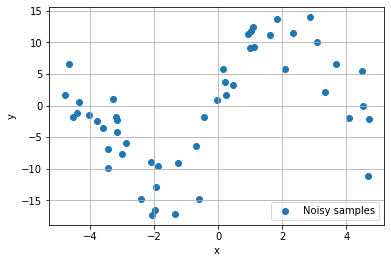

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

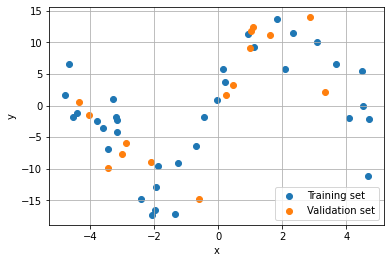

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

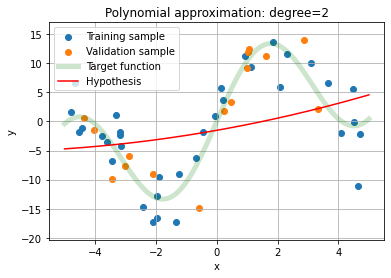

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

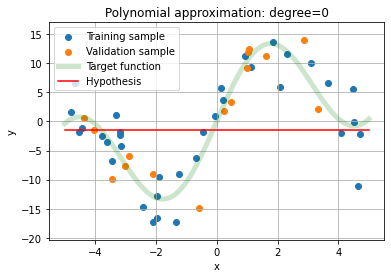

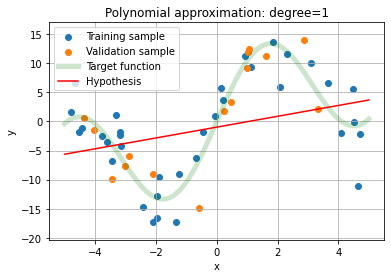

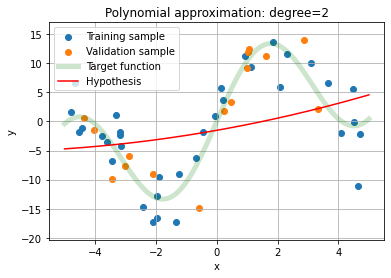

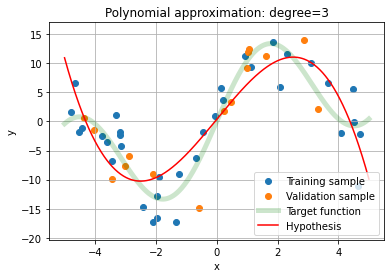

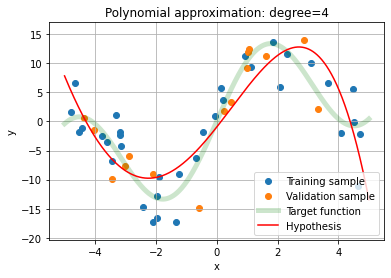

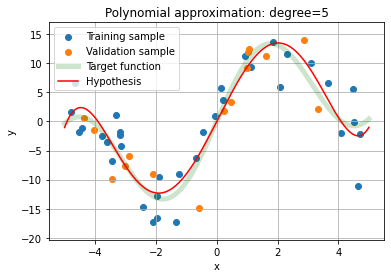

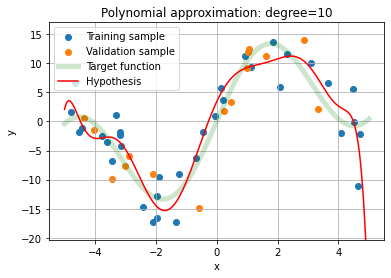

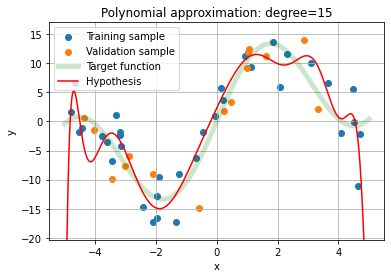

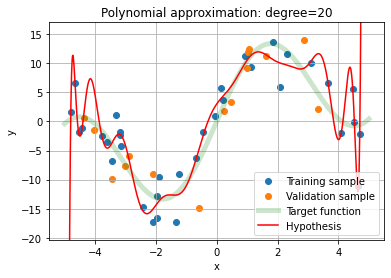

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

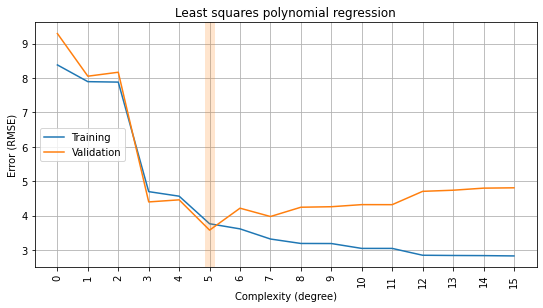

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

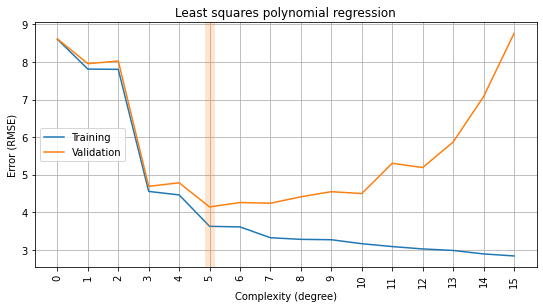

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

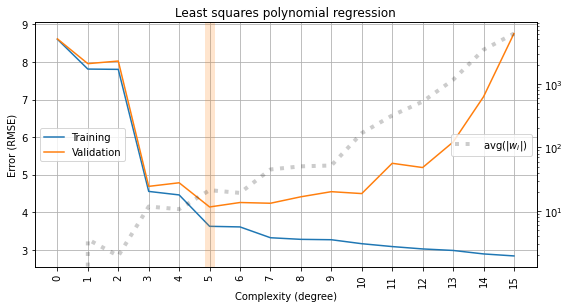

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

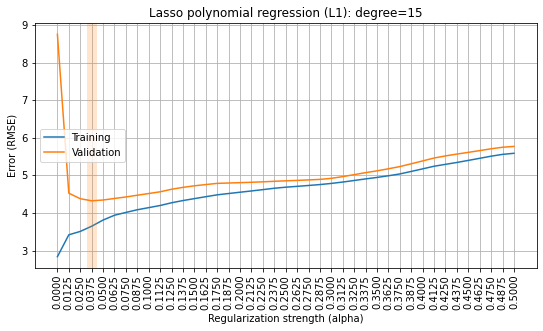

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

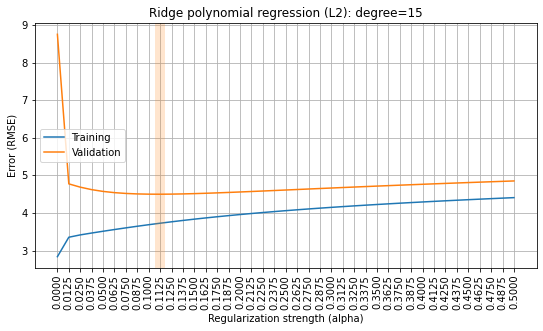

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Что за тип data diabetes?

In [21]:
type(data)

sklearn.utils.Bunch

Пример показателей данных

In [22]:
X_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Целевой показатель, уровень заболевания через 1 год

In [23]:
y_diabetes.head()

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [24]:
data['feature_names']

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [25]:
# your findings/conclusions

In [26]:
DEGREES

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

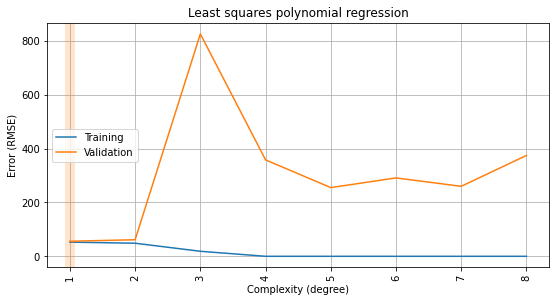

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3)
rmse_train, rmse_valid = [], []
DEGREES2 = [1, 2, 3, 4, 5, 6, 7, 8]
for degree in DEGREES2:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES2, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Самая маленькая ошибка возникает при degree = 1, это значит что модель при таком значении degree даст наиболее точные прогнозы. При degree = 3, наоборот - прогноз очень сильно отличается от настоящих результатов. Это связано с тем, что результат возведения в куб - это функция вида от минус бесконечности до плюс бесконечности, что совсем не соответствет анализируемым данным

In [28]:
DEGREES2[np.argmin(rmse_valid)]

1

In [29]:
DEGREES2[np.argmax(rmse_valid)]

3

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [30]:
## your code

In [31]:
ALPHAS

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   ])

In [56]:
for alpha in ALPHAS:
    coef = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_diabetes[['age', 's1', 'bmi']], y_diabetes)['reg'].coef_
    print(f'alpha {alpha} len {len(coef)} mean {coef.mean()} sum {abs(coef).sum()}')
#     print(coef)
            

 

alpha 0.0 len 1 mean -25152.12631700264 sum 10460329278.295597


c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.242e+05, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha 0.0125 len 815 mean 0.27730292361871905 sum 12126.811023126185


c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e+04, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha 0.025 len 815 mean 0.1345415081702025 sum 5804.76228956882


c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.478e+03, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha 0.037500000000000006 len 815 mean 0.03619039610112249 sum 3399.9906697024317


c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.810e+02, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha 0.05 len 815 mean -0.09028648172163542 sum 2093.586243686377
alpha 0.0625 len 815 mean -0.08427203728039556 sum 1659.9879933478621
alpha 0.07500000000000001 len 815 mean -0.060049811233860315 sum 1321.2154582566855
alpha 0.08750000000000001 len 815 mean -0.05460224103335599 sum 1129.336566408333
alpha 0.1 len 815 mean -0.04402303271019163 sum 1009.2027546484944
alpha 0.1125 len 815 mean -0.03553838267741698 sum 915.146676200103
alpha 0.125 len 815 mean -0.030429149190139233 sum 837.8920345098402
alpha 0.1375 len 815 mean -0.023599575744444684 sum 759.522044536518
alpha 0.15000000000000002 len 815 mean -0.018055546694056294 sum 685.7701412550845
alpha 0.1625 len 815 mean -0.012285279163524442 sum 623.5559381541298
alpha 0.17500000000000002 len 815 mean -0.0010780672755099628 sum 569.6140794208885
alpha 0.1875 len 815 mean 0.009129738654294636 sum 520.871178826424
alpha 0.2 len 815 mean 0.019710675442552773 sum 480.5915525826499
alpha 0.21250000000000002 len 815 mean 0.027803639683

<Figure size 648x324 with 0 Axes>

In [58]:
coef

array([[ 2.00882528e+01,  1.27626307e+01,  7.00907595e+01,
         1.01488870e+01, -1.01263171e+00,  1.98922337e+01,
         1.06729565e+01,  1.19596709e+01, -1.73242103e+00,
        -2.11525212e+01,  1.18686188e+01, -2.74007366e+01,
        -4.84177184e+00,  6.54116936e-01, -2.33957100e+00,
        -3.02579795e+01, -1.82861546e+01,  4.01797059e+00,
        -5.00658662e+01, -1.02630077e+01,  1.65168460e+00,
         7.40733724e-01, -1.38029189e+01, -1.22418881e+01,
        -3.76725226e+01, -1.46568410e+01, -2.23813714e+00,
        -9.01481423e+00, -2.49868842e+01, -1.39988756e+01,
         1.41656731e+01,  5.18907004e+00, -2.06357027e+01,
         2.92650730e+01,  9.92533363e+00, -2.72303496e+01,
         1.30761719e+01,  5.19844898e+00,  3.85744067e+01,
         7.35894509e+00, -7.45420674e+00,  6.65898509e+00,
         4.49951181e+01, -1.70876238e+01, -4.77385876e+00,
         1.69774133e+01,  2.62458827e+01, -4.54208886e+01,
        -8.71591467e+00,  2.17840949e+01, -1.24195488e+0

#### L2

In [33]:
## your code

In [57]:
for alpha in ALPHAS:
    coef = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_diabetes[['age', 's1', 'bmi']], y_diabetes)['reg'].coef_
    print(f'alpha {alpha} len {len(coef)} mean {coef.mean()} sum {abs(coef).sum()}')

alpha 0.0 len 1 mean -25152.12631700264 sum 10460329278.295597
alpha 0.0125 len 1 mean -1.288730556595146 sum 44174.01232075533
alpha 0.025 len 1 mean -0.10050753278105619 sum 30563.122783181832
alpha 0.037500000000000006 len 1 mean 0.27624794660186536 sum 24917.858513777104
alpha 0.05 len 1 mean 0.42530826501634356 sum 21545.250858271465
alpha 0.0625 len 1 mean 0.4847752177229732 sum 19216.48975228882
alpha 0.07500000000000001 len 1 mean 0.5030428398263922 sum 17504.931165722395
alpha 0.08750000000000001 len 1 mean 0.5007607303892455 sum 16184.718068564503
alpha 0.1 len 1 mean 0.4878534556968813 sum 15108.900298379409
alpha 0.1125 len 1 mean 0.4694770565137291 sum 14217.90387077988
alpha 0.125 len 1 mean 0.448453371395308 sum 13473.564715232227
alpha 0.1375 len 1 mean 0.42637926085107003 sum 12833.935937489774
alpha 0.15000000000000002 len 1 mean 0.40417451389841486 sum 12272.664914585905
alpha 0.1625 len 1 mean 0.3823698108903375 sum 11776.798005307524
alpha 0.17500000000000002 len 1

#### Summary

In [ ]:
## your observations/conclusions


Если использовать высокую степень degree=15, то коэффициенты модели становятся высоки, и возрастает возможная ошибка. Для уточнения можно использовать коэффициент регуляризации Альфа, который уменьшает разброс модели, на примере вычислений выше можно сделать вывод, что можно использовать Альфа = 0.1 для улучшения точности прогноза.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [36]:
## your code

In [60]:
for alpha in ALPHAS:
    coef = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_diabetes[['age', 's1', 'bmi']], y_diabetes)['reg'].coef_
    print(f'alpha{alpha}')
    print(coef)

alpha0.0
[[ 5.10009277e+03  1.31161125e+02 -4.35012091e+03  4.68356986e+03
   1.94198552e+04 -1.33548866e+04  1.15818309e+04 -1.30225683e+04
   2.30943347e+04 -1.55947526e+05 -1.18822386e+05  1.63883710e+05
  -2.44258703e+04  7.34609919e+04 -1.36706242e+05  4.78989881e+03
   1.37704450e+04 -1.23921907e+04  1.46730054e+05 -3.87227943e+04
  -2.91744598e+05  1.49731847e+05 -3.03522085e+04  4.99732331e+04
  -8.04843077e+04 -1.67634175e+05 -3.93756853e+04  2.07808389e+05
  -5.31369423e+04 -5.34011173e+05  2.93501425e+05 -1.51925485e+05
  -6.82399681e+03 -4.40469516e+05  1.83351117e+06  1.85852181e+06
  -2.01509261e+06  1.25435148e+06 -5.10943172e+05  1.69061375e+06
   1.87655871e+06 -8.47215672e+05 -7.68110649e+05 -1.65946484e+06
  -4.83183869e+04 -1.79522132e+06  6.26932694e+05  4.01811679e+05
   1.60916399e+06 -3.14829863e+05  2.38655904e+05  3.82925092e+05
  -4.03191659e+05 -1.82520806e+05 -2.47550639e+06  1.83483703e+05
   2.43282980e+06 -1.00881721e+06 -1.41057731e+06 -4.76469685e+05
 

c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.242e+05, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha0.0125
[ 3.39328347e+01  1.58023347e+01  8.37007161e+01  2.08385297e+01
 -0.00000000e+00  2.81594852e+01  8.27535454e+00  1.40573855e+01
  9.36889616e+00 -1.00277684e+02  0.00000000e+00 -5.77493623e+01
 -1.84332787e+01 -6.00936876e+00  4.19161254e+00 -2.21902574e+01
  7.21165426e+00 -2.26485489e+01 -1.04948951e+02 -3.96190027e+01
 -6.17305209e+00 -1.62453635e+01 -0.00000000e+00  0.00000000e+00
 -1.07636514e+02 -1.88519880e+01 -0.00000000e+00 -5.21898752e+01
 -5.65799394e+01 -1.23624421e+01  1.99746130e+00  2.91075169e+01
 -5.59037798e+01  0.00000000e+00  1.47776681e+02 -1.19132544e+01
  3.87349531e+01  7.16274540e+01  1.14333517e+02  2.26076096e-01
 -3.60879464e+01  0.00000000e+00  2.10409235e+02 -0.00000000e+00
  0.00000000e+00  9.71735512e+01  4.57381553e+01 -1.45503697e+02
 -9.73086649e+01 -0.00000000e+00 -2.26839114e+02 -0.00000000e+00
  4.63267608e+01  6.66700117e+00  1.14887263e+02 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  3.77730017e+01 -9.25915948e+01
  1.94695893e

c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e+04, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha0.025
[  18.93340351   12.5615378    75.43902853   12.66544829    0.
   22.10463934    8.82408798   11.13137635    0.          -10.72334373
    0.          -46.27447568  -10.14521272   -8.31492143   -2.23907705
  -22.07145583  -14.1208329    -4.71080713  -63.47405936  -28.84907562
   -0.           -0.           -1.31680951   -0.          -61.27159833
  -14.72613297   -0.28288153  -40.29383076  -39.04426931  -20.53723776
   21.56670248   14.23729837  -33.58110202   34.95924543    0.
  -14.1891215    32.40922751    0.           96.56546131    0.
   -0.            0.          137.58290535   -0.           -0.
   43.56348239   53.52889683  -66.39547825  -20.55949353   11.29129382
  -45.52510427    0.           14.2846304     0.           34.66104285
   -0.          -12.37739263   -1.22704662    0.          -86.59703064
  102.94723201    0.           -5.7522257   181.8830886    76.78942343
  -13.80801797   -6.50432583  -85.55346931   71.42390537    0.
   -0.           -0.           56.5

c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.478e+03, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha0.037500000000000006
[ 16.88863983  12.41236756  71.79528415   5.45156896  -2.1667817
  20.85437331   5.04244333  12.13928975  -2.96291614  -9.20578612
   0.94682282 -38.07808376  -4.96768425  -0.          -0.28495235
 -21.67837238 -23.92854411   0.         -48.91306023 -14.89745948
  -0.           0.          -3.38560434  -0.         -39.57137678
  -8.16048095  -0.         -13.60102923 -26.90266246 -11.7563228
  12.490364     5.93914706 -22.16603748  40.22591337  -0.
 -16.37991475  22.73993215   0.          66.56496896  -0.
   0.          -0.          68.70436973  -0.          -0.
  16.17464938  30.03256746 -54.82918345  -5.77183276  18.68170655
  -0.           9.16846372  12.35822802  -0.           9.08499622
  -0.          -0.          -0.           0.         -80.6656044
  54.42376525  -0.          -0.         108.87918585  38.70007276
  -0.          -5.35346754 -32.96257176  14.11597567   0.
  -0.          -0.           7.72431551 -10.49624645 -36.38297338
  -0.          -1.0

c:\users\svilsa\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.810e+02, tolerance: 2.621e+02
  model = cd_fast.enet_coordinate_descent(


alpha0.05
[ 16.63048982  10.58325513  67.2388875    0.          -1.10999294
  20.8782373    1.67148948  13.17319612  -4.4487946   -8.82529844
   6.03685467 -26.59510673  -2.48043187   0.           0.
 -16.02176221 -18.73656841   5.11433455 -37.86896594  -4.26969462
  -0.           0.          -0.          -8.81425715 -32.82806932
 -10.64046651  -0.         -22.66450329 -21.26769725  -0.
   8.46179777   2.28161211 -17.23887144  39.22698831  -0.
 -18.50783666   0.           0.          45.70343865   0.
   0.          -0.          19.10312798  -0.          -0.
  15.54155709   9.80584532 -36.49009497  -0.          15.8337748
  -0.           0.           0.          -0.           0.
  -0.          -0.          -0.           0.         -45.65349527
  58.73086812  -0.          -0.         102.09625889  24.43917588
  -0.          -8.04704523  -2.97413365   0.           0.
   0.           0.           0.         -11.86027019  -0.
  -0.         -15.43852103  -0.          -0.           0.
   0.  

alpha0.0625
[ 1.58701616e+01  1.07077662e+01  6.43021444e+01 -0.00000000e+00
 -1.45597972e+00  2.09316263e+01  1.22117840e+00  1.34087044e+01
 -4.62660208e+00 -8.43959878e+00  1.24306754e+00 -2.31228798e+01
 -4.16540766e-01  2.16250943e+00  1.26936995e+00 -1.26535003e+01
 -1.60640828e+01  3.77827357e+00 -3.18952576e+01 -2.52334103e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.64791697e+01
 -2.74636239e+01 -1.09017182e+01  0.00000000e+00 -2.21462133e+01
 -1.94141316e+01 -0.00000000e+00  7.11140308e+00  9.91162073e-01
 -1.09885357e+01  3.67878162e+01 -0.00000000e+00 -7.45102590e+00
  0.00000000e+00  0.00000000e+00  2.90624476e+01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  9.54977125e+00 -0.00000000e+00
 -0.00000000e+00  7.89402133e+00  6.85953251e+00 -2.88842056e+01
 -0.00000000e+00  1.14137967e+01 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  7.66413183e-01 -2.97668446e+01
  4.87778504e

alpha0.07500000000000001
[ 1.57957042e+01  9.75458904e+00  6.09621152e+01 -0.00000000e+00
 -1.47904957e+00  2.12573438e+01  1.83631322e-01  1.40218494e+01
 -4.87807950e+00 -1.02301450e+01  0.00000000e+00 -1.95923606e+01
 -0.00000000e+00  5.33834184e+00  2.51672415e+00 -7.03973459e+00
 -1.23173929e+01  2.02302289e+00 -2.45010079e+01 -1.66505500e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.58921931e+01
 -2.07003498e+01 -1.02432496e+01  0.00000000e+00 -1.93801980e+01
 -1.55250997e+01 -0.00000000e+00  3.55778999e+00  2.68506999e+00
 -5.47300622e+00  3.33455265e+01 -0.00000000e+00 -4.23861580e+00
  0.00000000e+00  0.00000000e+00  1.68601275e+01  0.00000000e+00
  0.00000000e+00 -4.35870335e+00  1.09655604e+01 -0.00000000e+00
 -0.00000000e+00  1.04183196e+00  5.44274841e+00 -2.63377404e+01
 -0.00000000e+00  3.13337974e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  7.75149596e+00 -1.12628085e+01


alpha0.08750000000000001
[ 15.77070693   9.16070686  58.04625     -0.55448082  -1.50419364
  20.98607768   0.          13.72058351  -3.83981093 -10.40212897
  -0.         -17.12956379  -0.           5.55398722   3.07561748
  -5.1548114   -7.99641087   1.24230345 -18.56634847  -0.
  -0.           0.           0.         -29.71605467 -18.11216401
  -9.92177947  -0.         -15.83960699 -14.88561853  -0.
   2.3023336    2.27325033  -1.61437878  27.3739841   -3.43155391
  -2.91173688   0.           0.          13.89054626   0.
  -0.          -7.79836549  11.60042857  -0.          -0.
   0.           4.52425586 -25.1148485   -0.           0.
   0.          -0.           0.          -0.           0.
  -0.          -0.          -0.          11.7784421   -0.
  32.22411089  -0.          -0.          81.78941649   2.98693028
   0.          -0.          -0.           0.           0.
   0.          -0.          -0.         -19.24466137  -0.
  -0.72391586  -0.08920263  -0.          -0.           0.

alpha0.1
[ 1.40704647e+01  8.67106293e+00  5.62386230e+01 -3.44850459e-01
 -1.74842412e+00  2.02619299e+01  5.90086222e-02  1.33722984e+01
 -2.82653923e+00 -0.00000000e+00 -0.00000000e+00 -1.57158758e+01
 -0.00000000e+00  4.68223617e+00  3.57714807e+00 -4.01955469e+00
 -5.17438259e+00  4.76555408e-01 -1.53367879e+01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.81642599e+01
 -1.63629204e+01 -9.06276336e+00 -0.00000000e+00 -1.39515390e+01
 -1.38725391e+01 -0.00000000e+00  1.88647817e+00  1.52794170e+00
 -0.00000000e+00  2.33748375e+01 -2.74896176e+01 -9.48231930e-01
  0.00000000e+00  0.00000000e+00  1.36112917e+01  0.00000000e+00
 -0.00000000e+00 -1.03581346e+01  1.13763098e+01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  3.65643035e+00 -2.36132348e+01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.23325593e+01 -0.00000000e+00
  2.89749556e+01

alpha0.1125
[ 1.41442986e+01  8.37132704e+00  5.45863964e+01 -2.49131334e-02
 -1.88285787e+00  1.93814091e+01  4.41646979e-01  1.36539068e+01
 -1.56140825e+00 -0.00000000e+00 -0.00000000e+00 -1.41821329e+01
 -0.00000000e+00  3.83426254e+00  3.54985130e+00 -3.33739003e+00
 -3.08382330e+00  0.00000000e+00 -1.24077768e+01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.68281733e+01
 -1.50782259e+01 -8.39095718e+00 -0.00000000e+00 -1.30156346e+01
 -1.18581325e+01 -0.00000000e+00  7.50827603e-01  0.00000000e+00
 -0.00000000e+00  1.91439916e+01 -2.85865424e+01 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.24655473e+01  0.00000000e+00
 -0.00000000e+00 -1.10622651e+01  1.18812280e+01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.62536517e+00 -2.18928920e+01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.20213977e+01 -0.00000000e+00
  2.65118980e

alpha0.125
[ 14.16928329   8.18319221  53.16366372  -0.          -1.91850109
  18.60233354   0.38205933  13.3596226   -0.67626862  -0.
   0.         -13.08994232   0.           2.95020571   3.4770155
  -2.84517804  -1.91580839   0.          -9.54733744  -0.
   0.           0.           0.71046909 -25.18838755 -14.07871709
  -7.78126853  -0.184095   -11.97424895 -10.27889224  -0.
   0.           0.          -0.          15.09885351 -29.44538545
  -0.           0.           0.          11.01948834   0.43435701
  -0.         -10.4315208   11.67053516  -0.          -0.
   0.           2.19062388 -19.77958107  -0.           0.
   0.          -0.          -0.          -0.           0.
  -0.          -0.          -0.          10.74280324  -0.
  24.57967384  -0.          -0.          69.03038375   0.
   0.          -0.          -0.          -0.           0.
   0.          -0.          -0.         -18.3912471   -0.
  -0.          -0.          -0.          -0.           0.
   0.         -16.8119

alpha0.1375
[ 1.38979218e+01  7.89684696e+00  5.18993771e+01 -0.00000000e+00
 -2.08652345e+00  1.78444221e+01  3.02983416e-01  1.28242811e+01
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.19731197e+01
  0.00000000e+00  2.73251931e+00  3.76365932e+00 -2.19094085e+00
 -7.79457990e-01  0.00000000e+00 -7.34288496e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.62478470e+00 -2.33665468e+01
 -1.27971604e+01 -6.80984431e+00 -1.36194219e+00 -9.93299306e+00
 -9.36956363e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.19834724e+01 -2.84346800e+01 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.53774725e+00  5.37047804e-01
 -0.00000000e+00 -9.38872948e+00  1.14413092e+01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.73911714e+00 -1.86750970e+01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  7.41629662e+00 -0.00000000e+00
  2.19931642e

alpha0.15000000000000002
[ 13.57332651   7.73313734  50.81781315  -0.          -2.03923447
  17.10310584   0.29210284  12.35757358  -0.          -0.
   0.         -10.8677051    0.           2.68102176   4.29964077
  -1.73057723  -0.           0.          -5.17854116   0.
   0.           0.           3.1930862  -21.51411879  -9.74088397
  -6.54097948  -2.43340099  -7.89930971  -8.76219795   0.
   0.           0.          -0.           9.40136847 -27.01828114
   0.           0.           0.           5.84548891   0.
  -0.          -8.96630725  11.90352444  -0.          -0.
   0.           0.67686198 -17.76685587  -0.           0.
   0.          -0.          -0.          -1.18724805   0.
   0.          -0.          -0.           5.67363977  -0.
  16.08510988  -0.          -0.          57.5763815    0.
   0.89084434  -0.          -0.          -0.          -0.
   0.          -0.          -0.         -13.51607186  -0.39388527
  -0.           0.          -0.          -0.          -0.
   0.  

alpha0.1625
[ 13.28179102   7.79196785  49.89417032  -0.          -1.95496857
  16.24635462   0.34662851  11.82136968  -0.          -0.
   0.          -9.76828444   0.           2.28344369   4.613861
  -1.69247137  -0.           0.          -2.96581482   0.
   0.           0.           3.52949274 -19.55738808  -6.43470055
  -6.68234148  -3.13011436  -5.86542745  -7.92755408   0.
   0.           0.          -0.           6.79405695 -25.61907171
   0.           0.           0.           3.62798266   0.
  -0.          -8.56811695  12.08350594  -0.          -0.
   0.           0.         -16.21719896  -0.           0.
   0.          -0.          -0.          -2.30655304   0.
   0.          -0.          -0.           4.36304265  -0.
   9.20547517  -0.          -0.          52.58452476   0.
   1.94185391  -0.           0.          -0.          -0.
   0.          -0.          -0.         -11.86078959  -1.84322579
  -0.           0.          -0.          -0.          -0.
   0.         -13.4480

alpha0.17500000000000002
[ 13.12644562   7.86327397  49.06385778  -0.          -1.85957939
  15.29158256   0.37125631  11.359445    -0.          -0.
   0.          -8.80668573   0.           1.79099154   4.53035795
  -1.67768791  -0.           0.          -1.07559356   0.
   0.           0.           3.82018643 -17.78119533  -3.77817164
  -6.71589536  -3.31835196  -4.37463155  -6.80498432   0.
   0.           0.          -0.19636397   4.4349971  -24.53405961
   0.           0.           0.           2.65208801   0.
  -0.          -8.03463578  11.88145909  -0.          -0.
   0.           0.         -14.62577326  -0.           0.
   0.          -0.          -0.          -3.11784361   0.
   0.          -0.          -0.           3.29698421  -0.
   4.51868946  -0.          -0.          48.2142873    0.
   2.707271    -0.           0.          -0.          -0.
   0.          -0.          -0.         -10.74996387  -2.97422057
  -0.           0.          -0.          -0.          -0.
   0.  

alpha0.1875
[ 13.03563828   7.83907652  48.5614242   -0.          -1.80160106
  14.29543397   0.37031544  10.93310478  -0.          -0.
   0.29188293  -8.13144427   0.           1.49533574   4.11532315
  -1.68481243  -0.           0.          -0.           0.
   0.           0.           4.52723508 -15.89898993  -1.12471199
  -6.58609513  -3.42776271  -2.88264463  -5.73259086   0.
   0.           0.          -0.7096048    2.81766503 -23.71034381
   0.           0.           0.           1.82942362   0.
  -0.          -7.76571379  11.36386603  -0.          -0.
   0.           0.         -13.47364819  -0.           0.
   0.          -0.          -0.          -3.34181903   0.
   0.          -0.          -0.           1.6004416   -0.
   0.          -0.          -0.          43.29181247   0.
   2.94494302  -0.           0.          -0.          -0.
   0.          -0.          -0.          -9.95265699  -3.61894351
  -0.           0.          -0.          -0.          -0.
   0.          -9.55

alpha0.2
[ 12.9001632    7.75633398  48.46197149  -0.          -1.89018726
  13.21662166   0.42549084  10.30740711  -0.          -0.
   0.75721904  -7.55001687   0.           1.10769062   3.84973016
  -1.73427419  -0.           0.          -0.           0.
   0.           0.           5.34695612 -13.91254602  -0.11376015
  -6.36913505  -3.6885826   -1.45254329  -4.54729376   0.
   0.           0.          -0.42961023   2.37988816 -22.99219906
   0.           0.           0.           0.91172905   0.
  -0.          -7.74803319  10.59974695  -0.          -0.
   0.           0.         -12.29247342  -0.          -0.
   0.          -0.          -0.          -2.92398309   0.
   0.          -0.          -0.           0.           0.
   0.          -0.          -0.          38.76161789   0.
   2.3734226   -0.           0.          -0.          -0.
   0.          -0.          -0.          -9.19498594  -4.1526722
  -0.           0.          -0.          -0.          -0.
   0.          -9.339757

alpha0.21250000000000002
[ 1.28502248e+01  7.61971142e+00  4.83977470e+01  0.00000000e+00
 -1.92921562e+00  1.21729143e+01  4.92309348e-01  9.67948136e+00
 -0.00000000e+00 -0.00000000e+00  1.29543515e+00 -7.13755270e+00
  0.00000000e+00  5.50789987e-01  3.41172324e+00 -1.72819505e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  5.14999316e+00 -1.20833291e+01
 -0.00000000e+00 -6.26527386e+00 -3.75439039e+00 -0.00000000e+00
 -3.17619728e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.29259731e+00 -2.24279217e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.35532961e-01  0.00000000e+00
 -0.00000000e+00 -7.76821534e+00  9.79308135e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.12489160e+01
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -2.33416577e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00


alpha0.225
[ 12.74014044   7.51446324  48.3104494    0.          -1.8139483
  11.27564987   0.55887341   9.29096872   0.          -0.
   1.48986199  -6.76630621   0.           0.           3.0657936
  -1.73109033  -0.          -0.          -0.           0.
   0.          -0.           4.61485214 -10.54683003  -0.
  -5.96087141  -3.99014787  -0.          -2.00436584   0.
   0.           0.          -0.           2.28382375 -21.64099776
   0.           0.           0.           0.87984954   0.
  -0.          -7.65541587   9.58212676  -0.          -0.
   0.           0.         -10.7684844   -0.          -0.
   0.          -0.          -0.          -1.78890661   0.
   0.          -0.          -0.           0.           0.
   0.13135138  -0.          -0.          32.10729714   0.
   2.60863968  -0.           0.          -0.          -0.
   0.          -0.          -0.          -8.13659307  -3.7276779
  -0.           0.          -0.          -0.          -0.
   0.          -9.92567472   0. 

alpha0.23750000000000002
[ 12.62351996   7.35230303  48.2378188    0.          -1.64581878
  10.55242357   0.65346839   8.84880228   0.          -0.
   1.70954526  -6.43274952   0.           0.           2.77965845
  -1.64728412  -0.          -0.          -0.           0.
   0.          -0.           4.09176267  -9.26775259  -0.
  -5.57436221  -4.24439221  -0.          -1.14193091   0.
   0.           0.          -0.           2.26310578 -20.95555814
   0.           0.           0.           0.61804787   0.
  -0.          -7.86593358   9.37999185  -0.          -0.
   0.           0.         -10.28862141  -0.          -0.
  -0.          -0.          -0.          -1.58652465   0.
   0.          -0.          -0.           0.           0.
   0.          -0.          -0.          29.46466182   0.
   2.96794545  -0.           0.          -0.          -0.
   0.          -0.          -0.          -7.54772261  -3.15458195
  -0.           0.          -0.          -0.          -0.
   0.          

alpha0.25
[ 12.49058833   7.18121717  48.19433508   0.          -1.34376733
  10.05866419   0.66459701   8.6874978    0.          -0.
   2.01100106  -6.28336667   0.           0.           2.65210633
  -1.47200801  -0.          -0.          -0.           0.
   0.          -0.           3.77143152  -8.4045585   -0.
  -5.33674645  -4.60489083  -0.          -0.6352311    0.
   0.           0.          -0.           2.18752223 -20.2124902
   0.           0.           0.           0.70814893   0.
  -0.          -7.9018907    8.60663883  -0.          -0.
   0.           0.         -10.01524232  -0.          -0.
  -0.          -0.          -0.          -0.95870377   0.
   0.          -0.          -0.           0.          -0.
   0.          -0.          -0.          27.26989957   0.
   3.03440874  -0.           0.          -0.          -0.
   0.          -0.          -0.          -6.93520605  -3.07993848
  -0.          -0.          -0.          -0.          -0.
   0.          -9.83079748   0.

alpha0.2625
[ 1.24054603e+01  7.00830264e+00  4.81322535e+01  0.00000000e+00
 -1.01867572e+00  9.59590117e+00  5.00597697e-01  8.42140394e+00
  0.00000000e+00 -0.00000000e+00  2.20122027e+00 -6.16881135e+00
  0.00000000e+00  0.00000000e+00  2.50177616e+00 -1.14167011e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  3.41324392e+00 -7.44920235e+00
 -0.00000000e+00 -5.23181983e+00 -4.92598796e+00 -0.00000000e+00
 -9.16972587e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.11652953e+00 -1.94766352e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.33693844e-01  0.00000000e+00
 -0.00000000e+00 -7.83140281e+00  7.76048051e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -9.55086614e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -3.57195384e-01  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e

alpha0.275
[ 1.22823403e+01  6.87473590e+00  4.80435979e+01  0.00000000e+00
 -8.36570901e-01  9.36228423e+00  4.26766227e-01  8.11511692e+00
  0.00000000e+00 -0.00000000e+00  2.41383198e+00 -6.07906883e+00
  0.00000000e+00  0.00000000e+00  2.47072083e+00 -9.45806488e-01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  3.15293185e+00 -6.53837388e+00
 -0.00000000e+00 -5.02564595e+00 -5.26417982e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.19724225e+00 -1.88374439e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.88460581e-01  0.00000000e+00
 -0.00000000e+00 -7.82589012e+00  7.03841186e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -9.13202011e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+

alpha0.28750000000000003
[ 12.09799846   6.7851113   47.95291682   0.          -0.76327931
   9.15140587   0.42927765   7.86928505   0.          -0.
   2.71258914  -5.92963012   0.           0.           2.55465667
  -0.89331192  -0.          -0.          -0.           0.
   0.          -0.           3.04483894  -5.8296319   -0.
  -4.79497017  -5.56126418  -0.          -0.           0.
   0.           0.          -0.           2.29400631 -18.22960883
   0.           0.           0.           0.81407569   0.
  -0.          -7.95684146   6.2143923   -0.          -0.
  -0.           0.          -8.71370976  -0.          -0.
  -0.          -0.          -0.          -0.           0.
   0.          -0.          -0.           0.          -0.
   0.          -0.          -0.          22.40451066  -0.
   3.02568224  -0.           0.          -0.          -0.
   0.          -0.          -0.          -5.33143969  -3.11361439
  -0.          -0.          -0.          -0.          -0.
   0.         -

alpha0.30000000000000004
[ 11.91105081   6.68833639  47.86542115   0.          -0.65272549
   8.93136115   0.44415631   7.60896099   0.          -0.
   3.03490507  -5.78045736   0.           0.           2.64262997
  -0.85075955  -0.          -0.          -0.           0.
  -0.          -0.           2.92903434  -5.06419154  -0.
  -4.58463149  -5.84090577  -0.          -0.           0.
   0.           0.          -0.           2.38658572 -17.65758912
   0.           0.           0.           0.95318504   0.
  -0.          -8.11150514   5.40811705  -0.          -0.
  -0.           0.          -8.31304336  -0.          -0.
  -0.          -0.          -0.          -0.           0.
   0.          -0.          -0.11026835   0.          -0.
   0.          -0.          -0.          20.97868044  -0.
   2.49961885  -0.           0.          -0.          -0.
  -0.          -0.          -0.          -4.75159628  -2.95736846
  -0.          -0.          -0.          -0.          -0.
   0.         -

alpha0.3125
[ 1.17406792e+01  6.58288357e+00  4.77959207e+01  0.00000000e+00
 -4.84312271e-01  8.89700497e+00  4.70459887e-01  7.33639509e+00
  0.00000000e+00 -0.00000000e+00  3.41191343e+00 -5.64768614e+00
  0.00000000e+00  0.00000000e+00  2.69816889e+00 -8.28302444e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.83682473e+00 -4.24996659e+00
 -0.00000000e+00 -4.40713274e+00 -6.17060059e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.37917783e+00 -1.71225668e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.09007883e+00  0.00000000e+00
 -0.00000000e+00 -8.21170524e+00  4.45895454e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -7.81995334e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.87229552e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e

alpha0.325
[ 11.54462345   6.48175193  47.72555024   0.          -0.33176872
   8.83408336   0.49965226   7.04041873   0.          -0.
   3.77161945  -5.50593904   0.           0.           2.7584482
  -0.82312875  -0.           0.           0.           0.
  -0.          -0.           2.75711881  -3.45225678  -0.
  -4.14918316  -6.50937034  -0.          -0.          -0.
   0.           0.          -0.           2.35256225 -16.51792345
   0.           0.           0.           1.23275371   0.
  -0.          -8.26807184   3.55759136  -0.          -0.
  -0.           0.          -7.3379773   -0.          -0.
  -0.          -0.          -0.          -0.           0.
   0.          -0.          -3.37619777   0.          -0.
   0.          -0.          -0.          18.00277005  -0.
   1.40278413  -0.           0.          -0.          -0.
  -0.          -0.          -0.          -3.32677587  -2.91507646
  -0.          -0.          -0.          -0.          -0.
   0.         -10.00576592   0

alpha0.3375
[ 11.33689666   6.35010963  47.67155212   0.          -0.23579971
   8.79350671   0.48444071   6.74362009   0.          -0.
   4.15082874  -5.40558599   0.           0.           2.83735333
  -0.70952852  -0.           0.           0.           0.
  -0.          -0.           2.7775802   -2.65537292  -0.
  -3.78997091  -6.88305661  -0.          -0.          -0.
   0.           0.          -0.           2.31432174 -15.91690747
   0.           0.           0.           1.44787672   0.
  -0.          -8.39326078   2.72214786  -0.          -0.
  -0.           0.          -6.87022014  -0.          -0.
  -0.          -0.          -0.          -0.           0.
   0.          -0.          -4.57596563   0.          -0.
  -0.          -0.          -0.          16.65214035  -0.
   0.75213451  -0.           0.          -0.          -0.
  -0.          -0.          -0.          -2.67248243  -2.90106321
  -0.          -0.          -0.          -0.          -0.
   0.          -9.79930074  

alpha0.35000000000000003
[ 11.09542248   6.25254821  47.59118514   0.          -0.11269534
   8.7905173    0.46844946   6.41280171   0.          -0.
   4.49135893  -5.31424478   0.           0.           2.93612424
  -0.65130798  -0.           0.           0.           0.
  -0.          -0.           2.80226522  -1.94760132  -0.
  -3.70128597  -7.12169031  -0.          -0.          -0.
   0.           0.          -0.           2.3444306  -15.19179754
   0.           0.           0.           1.61786185   0.
  -0.          -8.36998328   1.95051085  -0.          -0.
  -0.           0.          -6.41525951  -0.          -0.
  -0.          -0.          -0.          -0.           0.
   0.          -0.          -5.8313355    0.          -0.
  -0.          -0.          -0.          15.4377538   -0.
   0.26532633  -0.           0.          -0.          -0.
  -0.          -0.          -0.          -2.23257527  -2.79048278
  -0.          -0.          -0.          -0.          -0.
   0.          

alpha0.375
[ 1.06215762e+01  6.09262664e+00  4.74429197e+01  0.00000000e+00
 -0.00000000e+00  8.72154281e+00  4.16841586e-01  5.77151258e+00
  0.00000000e+00 -0.00000000e+00  5.09991721e+00 -5.17734005e+00
  0.00000000e+00  0.00000000e+00  3.11847425e+00 -5.55086118e-01
 -4.19431676e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.54449393e+00 -5.80556747e-01
 -0.00000000e+00 -3.42828602e+00 -7.58136269e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.43970695e+00 -1.37725596e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.86201456e+00  0.00000000e+00
 -0.00000000e+00 -8.16022678e+00  5.03495210e-01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.46782883e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -7.79553822e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+

alpha0.4
[ 1.02276200e+01  5.98328476e+00  4.73486574e+01  0.00000000e+00
 -0.00000000e+00  8.43169399e+00  2.78977733e-01  5.30945164e+00
  0.00000000e+00 -0.00000000e+00  5.28552665e+00 -5.15921900e+00
  0.00000000e+00  0.00000000e+00  3.24215211e+00 -5.33412441e-01
 -3.97955824e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.34044298e+00 -0.00000000e+00
 -0.00000000e+00 -2.99438799e+00 -7.95570012e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.51521419e+00 -1.24890891e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.92797851e+00  0.00000000e+00
 -0.00000000e+00 -7.85700011e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -4.98711204e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -7.37504182e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00

alpha0.4375
[ 9.80763344e+00  5.81247469e+00  4.72817362e+01  0.00000000e+00
 -0.00000000e+00  7.90735659e+00  2.90816271e-03  4.83138298e+00
  0.00000000e+00 -0.00000000e+00  5.15109496e+00 -5.23330986e+00
  0.00000000e+00  0.00000000e+00  3.46756704e+00 -3.35173509e-01
 -1.80179511e-01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.15828490e+00 -0.00000000e+00
 -0.00000000e+00 -2.55046779e+00 -7.40380969e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.50886090e+00 -1.10634319e+01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.73506318e+00  0.00000000e+00
 -0.00000000e+00 -7.14367051e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.09994295e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -6.06367615e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e

alpha0.47500000000000003
[ 9.39356698e+00  5.67474122e+00  4.71594498e+01  0.00000000e+00
 -0.00000000e+00  7.54868001e+00  0.00000000e+00  4.40422799e+00
  0.00000000e+00 -0.00000000e+00  4.86087450e+00 -5.01901864e+00
  0.00000000e+00  0.00000000e+00  3.58589003e+00 -1.24014532e-01
 -2.88985532e-01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.71811563e+00 -0.00000000e+00
 -0.00000000e+00 -2.25057207e+00 -6.85478630e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.41538216e+00 -9.70033853e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  8.55599097e-01  0.00000000e+00
 -0.00000000e+00 -6.55900195e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.01995181e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -5.37554049e+00  0.00000000e+00 -0.00000000e+00


#### L2

In [37]:
## your code

In [61]:
for alpha in ALPHAS:
    coef = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_diabetes[['age', 's1', 'bmi']], y_diabetes)['reg'].coef_
    print(f'alpha{alpha}')
    print(coef)

alpha0.0
[[ 5.10009277e+03  1.31161125e+02 -4.35012091e+03  4.68356986e+03
   1.94198552e+04 -1.33548866e+04  1.15818309e+04 -1.30225683e+04
   2.30943347e+04 -1.55947526e+05 -1.18822386e+05  1.63883710e+05
  -2.44258703e+04  7.34609919e+04 -1.36706242e+05  4.78989881e+03
   1.37704450e+04 -1.23921907e+04  1.46730054e+05 -3.87227943e+04
  -2.91744598e+05  1.49731847e+05 -3.03522085e+04  4.99732331e+04
  -8.04843077e+04 -1.67634175e+05 -3.93756853e+04  2.07808389e+05
  -5.31369423e+04 -5.34011173e+05  2.93501425e+05 -1.51925485e+05
  -6.82399681e+03 -4.40469516e+05  1.83351117e+06  1.85852181e+06
  -2.01509261e+06  1.25435148e+06 -5.10943172e+05  1.69061375e+06
   1.87655871e+06 -8.47215672e+05 -7.68110649e+05 -1.65946484e+06
  -4.83183869e+04 -1.79522132e+06  6.26932694e+05  4.01811679e+05
   1.60916399e+06 -3.14829863e+05  2.38655904e+05  3.82925092e+05
  -4.03191659e+05 -1.82520806e+05 -2.47550639e+06  1.83483703e+05
   2.43282980e+06 -1.00881721e+06 -1.41057731e+06 -4.76469685e+05
 

alpha0.08750000000000001
[[ 3.02226372e+01  1.54882487e+01  8.19601156e+01  1.79443859e+01
   1.73546401e-01  2.89792655e+01  1.19665033e+01  1.25515379e+01
   3.53130777e+00 -7.22053142e+01  2.05109256e+01 -5.33324661e+01
  -1.91576433e+01 -7.41117066e+00 -2.48734445e+00 -3.15155127e+01
  -1.49471908e+01 -1.90514678e+01 -9.20639334e+01 -2.16794707e+01
   7.75778447e+00 -2.84455710e+01  6.27989663e+00  3.00573803e+01
  -6.71106847e+01 -2.01689065e+01 -1.89847795e+00 -2.82860941e+01
  -5.51674204e+01 -1.92899361e+01  1.17846511e+01  2.51571178e+01
  -5.36621655e+01  2.00019919e+01  8.26515038e+01 -6.31919790e+01
   3.15654914e+01  4.37296438e+01  8.70264525e+01  2.38840929e+01
  -3.10479902e+01  4.26042083e+01  1.52323014e+02  4.76044278e+00
   1.88025678e+01  5.62008787e+01  5.35611277e+01 -9.09728740e+01
  -4.39352116e+01  2.10370348e+01 -9.71803042e+01  1.88969547e+01
   4.84728781e+01  1.13445209e+01  6.98009641e+01 -3.99901934e+01
  -1.85376255e+01  2.89012036e+01  4.37818798e+00 -

alpha0.1625
[[ 2.53816471e+01  1.45887702e+01  7.80931509e+01  1.60727226e+01
   9.03694570e-01  2.43534542e+01  1.30651799e+01  1.20564365e+01
   1.13897494e+00 -4.76522946e+01  1.77129676e+01 -4.29188278e+01
  -9.51560379e+00 -3.42889171e+00 -2.26499440e+00 -3.42092242e+01
  -1.80332625e+01 -9.16181312e+00 -7.55232387e+01 -1.88845884e+01
   2.61126049e+00 -1.18601966e+01 -7.69017756e+00  1.00047213e+01
  -5.73285115e+01 -1.94594616e+01 -1.56637598e+00 -1.96487762e+01
  -4.25441711e+01 -1.94666302e+01  1.39831869e+01  1.46299744e+01
  -3.83444980e+01  2.86424771e+01  4.83137892e+01 -4.75091616e+01
   2.51870597e+01  1.80780424e+01  6.77770464e+01  1.55825811e+01
  -2.12537570e+01  2.59321714e+01  1.04662259e+02 -8.47370842e+00
   3.51656733e+00  3.67969904e+01  4.10431833e+01 -7.40696109e+01
  -2.89643359e+01  2.59744863e+01 -5.67657240e+01  1.16425177e+01
   3.02689389e+01  8.53712621e+00  4.61162243e+01 -3.01089565e+01
  -1.27780675e+01  6.48149099e+00  1.97944198e+01 -9.98462178e+0

[[ 2.34807344e+01  1.40345594e+01  7.59433328e+01  1.45400822e+01
   6.99965427e-01  2.26557592e+01  1.28459037e+01  1.19641640e+01
   1.33619368e-01 -3.77319563e+01  1.61489972e+01 -3.79601667e+01
  -7.05925643e+00 -1.94608159e+00 -2.42627479e+00 -3.40461250e+01
  -1.89586228e+01 -4.43271038e+00 -6.77210675e+01 -1.63430660e+01
   1.28673699e+00 -6.31393560e+00 -1.16325076e+01  1.51851527e+00
  -5.17794648e+01 -1.84051590e+01 -1.78636037e+00 -1.60295449e+01
  -3.67817935e+01 -1.82103421e+01  1.44747111e+01  1.05324574e+01
  -3.18644161e+01  3.05334736e+01  3.42190231e+01 -4.08680903e+01
   2.14567873e+01  1.11115352e+01  5.86020103e+01  1.23270060e+01
  -1.64370328e+01  1.93128307e+01  8.35742356e+01 -1.27889892e+01
  -6.96443602e-01  2.94406503e+01  3.58372623e+01 -6.52402608e+01
  -2.16817553e+01  2.60270409e+01 -4.02556889e+01  8.03114391e+00
   2.31009884e+01  6.26548821e+00  3.67973760e+01 -2.60829142e+01
  -9.73977026e+00 -3.43437580e-01  2.24614800e+01 -8.00975790e+01
   6.57315

[[ 2.22793672e+01  1.36214807e+01  7.42419906e+01  1.32461292e+01
   3.14394271e-01  2.16322722e+01  1.23845198e+01  1.19460112e+01
  -5.28658831e-01 -3.15424130e+01  1.48890373e+01 -3.44800821e+01
  -5.98202950e+00 -1.01764692e+00 -2.51752602e+00 -3.33305333e+01
  -1.92125499e+01 -1.29875583e+00 -6.21276118e+01 -1.43436465e+01
   9.13792653e-01 -3.30495703e+00 -1.32978089e+01 -3.76919266e+00
  -4.74678168e+01 -1.73509911e+01 -1.96831107e+00 -1.36337727e+01
  -3.28150344e+01 -1.69736950e+01  1.45798921e+01  8.21878812e+00
  -2.77534910e+01  3.09357192e+01  2.52932604e+01 -3.63463884e+01
   1.86960463e+01  7.96590245e+00  5.20514989e+01  1.03645052e+01
  -1.31846717e+01  1.49828780e+01  6.97568075e+01 -1.49454216e+01
  -2.68504487e+00  2.48996044e+01  3.24757350e+01 -5.87990725e+01
  -1.68847397e+01  2.52385151e+01 -2.98934141e+01  5.59815869e+00
   1.85295816e+01  4.38154850e+00  3.09821786e+01 -2.33618451e+01
  -7.65810052e+00 -3.78004482e+00  2.27824442e+01 -6.71492369e+01
   5.89187

[[ 2.12881344e+01  1.32474067e+01  7.25573821e+01  1.19623082e+01
  -1.87322599e-01  2.08225507e+01  1.17611668e+01  1.19506351e+01
  -1.08249831e+00 -2.66254222e+01  1.36419925e+01 -3.13868876e+01
  -5.36077177e+00 -2.54490352e-01 -2.52227636e+00 -3.22599652e+01
  -1.90746314e+01  1.24366389e+00 -5.69996329e+01 -1.25286405e+01
   9.93385145e-01 -1.21222425e+00 -1.39933946e+01 -7.88583596e+00
  -4.33461239e+01 -1.62347573e+01 -2.11099722e+00 -1.15828343e+01
  -2.93480546e+01 -1.57175904e+01  1.45025903e+01  6.61250250e+00
  -2.44375584e+01  3.06218593e+01  1.80949213e+01 -3.23640224e+01
   1.62144953e+01  6.22679549e+00  4.61667566e+01  8.87779154e+00
  -1.04926084e+01  1.12826437e+01  5.83312515e+01 -1.62456658e+01
  -3.88067657e+00  2.12388789e+01  2.96661481e+01 -5.29655667e+01
  -1.30032215e+01  2.40108079e+01 -2.16303123e+01  3.59938294e+00
   1.47423303e+01  2.58602003e+00  2.63222644e+01 -2.09686732e+01
  -5.89783677e+00 -5.98800204e+00  2.21360547e+01 -5.64335179e+01
   5.26916

alpha0.4375
[[ 2.05657964e+01  1.29590790e+01  7.11333151e+01  1.09023077e+01
  -6.58711936e-01  2.02553779e+01  1.11507584e+01  1.19579265e+01
  -1.47956126e+00 -2.32475288e+01  1.26066677e+01 -2.90139172e+01
  -5.02816537e+00  2.96344315e-01 -2.44513931e+00 -3.11537315e+01
  -1.86946977e+01  2.97513604e+00 -5.29241731e+01 -1.11624312e+01
   1.31343409e+00  4.58378112e-02 -1.40253528e+01 -1.06163673e+01
  -4.00131478e+01 -1.53044612e+01 -2.19558536e+00 -1.00465871e+01
  -2.67347555e+01 -1.47002646e+01  1.43339956e+01  5.67884316e+00
  -2.21125320e+01  2.99435396e+01  1.30757383e+01 -2.93105538e+01
   1.43313735e+01  5.47077933e+00  4.16405203e+01  7.91772047e+00
  -8.61460520e+00  8.51316552e+00  5.01920077e+01 -1.68569664e+01
  -4.48922183e+00  1.86439086e+01  2.76066529e+01 -4.84673785e+01
  -1.03428507e+01  2.27652846e+01 -1.59441992e+01  2.21799778e+00
   1.20003456e+01  1.18637623e+00  2.30752958e+01 -1.91326070e+01
  -4.62740345e+00 -7.20231104e+00  2.11339360e+01 -4.88030056e+0

#### Summary

In [38]:
# your findings/conclusions

При увеличении коэффициента Альфа для модели Лассо все более часто некоторые веса приравниваются к 0

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [62]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [40]:
## your code

In [65]:
len(X_hw)

50

In [64]:
for alpha in ALPHAS:
    coef = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_hw, y_hw)['reg'].coef_
    print(f'alpha {alpha} len {len(coef)} mean {coef.mean()} sum {abs(coef).sum()}')
#     print()

alpha 0.0 len 815 mean 0.03956103272582285 sum 2476.518685362266
alpha 0.0125 len 815 mean 0.0045789598618504205 sum 97.69933904994116
alpha 0.025 len 815 mean 0.005119245131974207 sum 62.27360282711381
alpha 0.037500000000000006 len 815 mean 0.006052679305026971 sum 46.1371573492063
alpha 0.05 len 815 mean 0.0061978596970654175 sum 38.28386732446786
alpha 0.0625 len 815 mean 0.005786690987396338 sum 32.62502608700639
alpha 0.07500000000000001 len 815 mean 0.00512316732550013 sum 28.14781096995216
alpha 0.08750000000000001 len 815 mean 0.004505908482657218 sum 24.375958712003083
alpha 0.1 len 815 mean 0.0038079578340105263 sum 22.188680651609076
alpha 0.1125 len 815 mean 0.0038596314571413075 sum 20.449783906189424
alpha 0.125 len 815 mean 0.004162737554532042 sum 18.76307384003516
alpha 0.1375 len 815 mean 0.00432665284553022 sum 17.439647944942084
alpha 0.15000000000000002 len 815 mean 0.004394490031647246 sum 16.19071104048484
alpha 0.1625 len 815 mean 0.004451375549429082 sum 15.29

#### L2

In [41]:
## your code

In [66]:
for alpha in ALPHAS:
    coef = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_hw, y_hw)['reg'].coef_
    print(f'alpha {alpha} len {len(coef)} mean {coef.mean()} sum {abs(coef).sum()}')

alpha 0.0 len 815 mean 0.03956103272582285 sum 2476.518685362266
alpha 0.0125 len 815 mean 0.00811220080863204 sum 594.5301753670342
alpha 0.025 len 815 mean 0.006122817470936443 sum 460.7791051080727
alpha 0.037500000000000006 len 815 mean 0.005587567227215027 sum 408.8672106793839
alpha 0.05 len 815 mean 0.005395785044597743 sum 379.3060069348169
alpha 0.0625 len 815 mean 0.005322428196557976 sum 359.13495784750876
alpha 0.07500000000000001 len 815 mean 0.005298091622271698 sum 344.4804806582798
alpha 0.08750000000000001 len 815 mean 0.0052962535271857455 sum 332.6601391587623
alpha 0.1 len 815 mean 0.005305361963916479 sum 323.0528539421184
alpha 0.1125 len 815 mean 0.0053199301913226665 sum 314.7467686262589
alpha 0.125 len 815 mean 0.005337193740992813 sum 307.41251617540297
alpha 0.1375 len 815 mean 0.005355703592392895 sum 300.76122119920194
alpha 0.15000000000000002 len 815 mean 0.0053746819822744285 sum 294.6692671148119
alpha 0.1625 len 815 mean 0.005393707787610664 sum 289.0

#### Summary



In [42]:
## your observations/conclusions